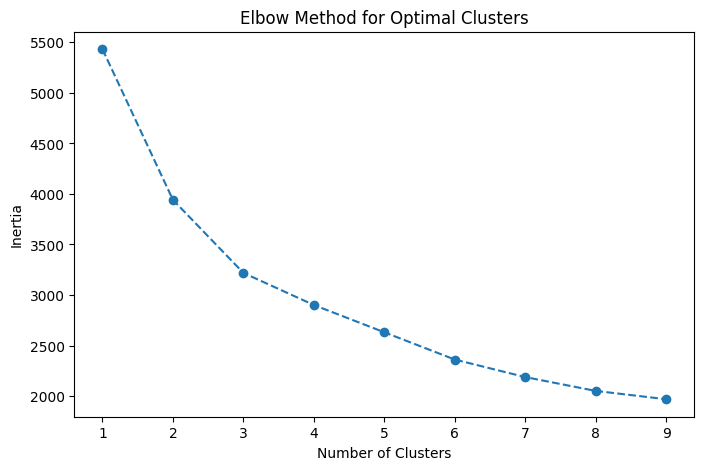

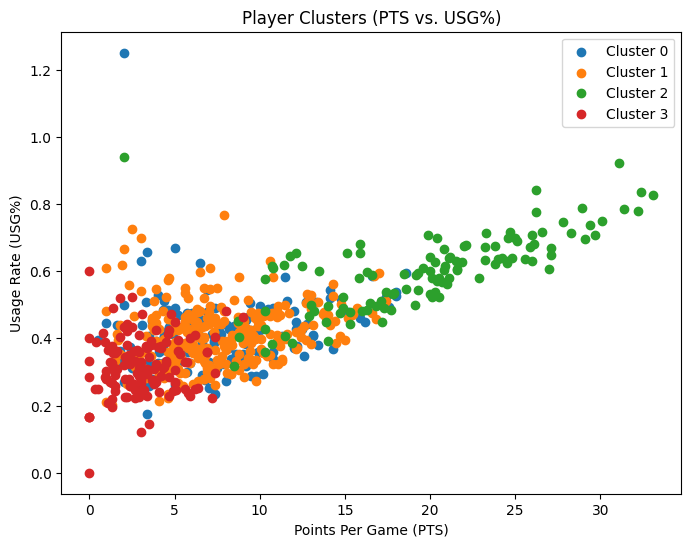

Linear Regression Mean Squared Error: 5.35386935762715
Linear Regression R-squared: 0.8735875158386541
Linear Regression Coefficients: {'AST': 0.8009869583294036, 'TRB': 1.8260729988503281, 'PER': -0.7834584318271695, 'TS%': 7.997309383261035, 'USG%': 21.175557449428133, 'AST/TO': -0.21691619079486224, 'Rebound Efficiency': -30.012283249351427}
Random Forest Mean Squared Error: 2.529192227941177
Random Forest R-squared: 0.9402821676998644


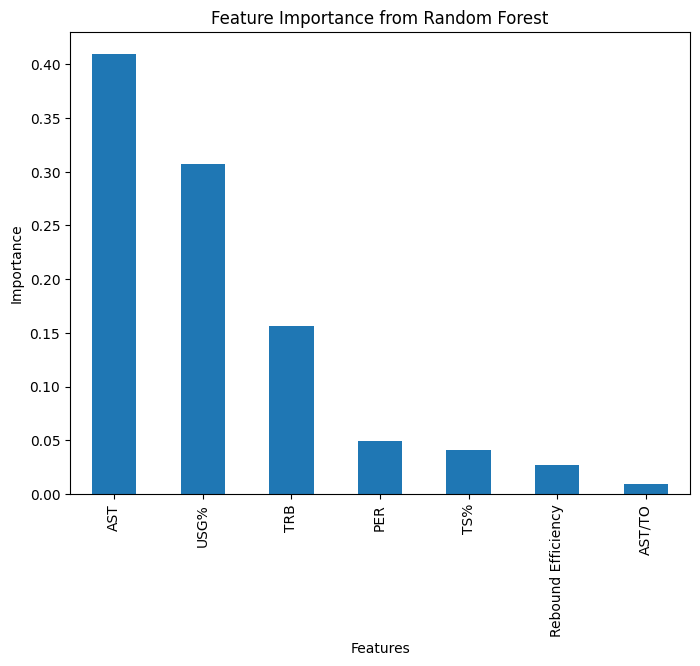

Random Forest Cross-Validation R-squared Scores: [0.93955477 0.950621   0.91444394 0.91351542 0.91478589]
Average Cross-Validation R-squared: 0.9265842048473617


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


file_path = 'NBA Player Stats Dataset for the 2022-2023  export 2024-10-31 17-18-49.csv'
nba_data = pd.read_csv(file_path)

def calculate_per(row):
    try:
        return (row['PTS'] + row['TRB'] + row['AST'] + row['STL'] + row['BLK']) / row['MP']
    except ZeroDivisionError:
        return 0

def calculate_ts(row):
    try:
        return row['PTS'] / (2 * (row['FGA'] + 0.44 * row['FTA']))
    except ZeroDivisionError:
        return 0

nba_data['PER'] = nba_data.apply(calculate_per, axis=1)
nba_data['TS%'] = nba_data.apply(calculate_ts, axis=1)
nba_data['AST/TO'] = nba_data['AST'] / nba_data['TOV'].replace(0, 1)
nba_data['Rebound Efficiency'] = nba_data['TRB'] / nba_data['MP']
nba_data['USG%'] = (nba_data['FGA'] + 0.44 * nba_data['FTA'] + nba_data['TOV']) / nba_data['MP']

features = ['PTS', 'AST', 'TRB', 'PER', 'TS%', 'AST/TO', 'Rebound Efficiency', 'USG%']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(nba_data[features])

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
nba_data['Cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(8, 6))
for cluster in range(optimal_clusters):
    cluster_data = nba_data[nba_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PTS'], cluster_data['USG%'], label=f'Cluster {cluster}')


plt.xlabel('Points Per Game (PTS)')
plt.ylabel('Usage Rate (USG%)')
plt.title('Player Clusters (PTS vs. USG%)')
plt.legend()
plt.show()


X = nba_data[['AST', 'TRB', 'PER', 'TS%', 'USG%', 'AST/TO', 'Rebound Efficiency']]
y = nba_data['PTS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred_lr = regressor.predict(X_test)


mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Mean Squared Error:", mse_lr)
print("Linear Regression R-squared:", r2_lr)
print("Linear Regression Coefficients:", dict(zip(X.columns, regressor.coef_)))


rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R-squared:", r2_rf)


feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar', figsize=(8, 6))
plt.title('Feature Importance from Random Forest')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Random Forest Cross-Validation R-squared Scores:", cv_scores_rf)
print("Average Cross-Validation R-squared:", cv_scores_rf.mean())